# 1 Exploring Hyperparameters

**Assigned Hyperparameter:** number of convolutional layers <br>

**Approach:** I did a quick research on the number of convolutional layers of "famous" models. Therefore, models were trained with the following amount of convolutional layers: <br>
- 0: for comparison with a model with no convolutional layers <br>
- 2: LeNet-5 (https://en.wikipedia.org/wiki/LeNet)<br>
- 3: model from last exercise session for comparison <br>
- 5: AlexNet (https://en.wikipedia.org/wiki/LeNet) <br>
- 13: VGG16 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6775529/#:~:text=The%20architecture%20of%20VGG%2D16,and%203%20fully%20connected%20layers.) <br>

(Note that I only adapted the number of convolutional layers from these models, not the kernel size etc.)<br>

**Assumptions:** I would assume that the model with no convolutional layers performs worst. Probably there will not be a big difference between the models with 2, 3 and 5 convolutional layers.

In [9]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [10]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'C:/Users/sinas/ITTCode/assignment-05-cnn-sina-sch/data/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [11]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [12]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in os.listdir("C:/Users/sinas/ITTCode/assignment-05-cnn-sina-sch/data/" + condition):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'C:/Users/sinas/ITTCode/assignment-05-cnn-sina-sch/data/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

## let's have a look at one of the images

In [ ]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [14]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


In [ ]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

### Model with 13 convolutional layers

In [46]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_13 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_13.add(RandomFlip('horizontal'))
model_13.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_13.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_13.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_13.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_13.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_13.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_13.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_13.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_13.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_13.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_13.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model_13.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_13.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_13.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_13.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_13.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_13.add(Flatten())

# add some fully connected layers ("Dense")v
for i in range(layer_count - 1):
    model_13.add(Dense(num_neurons, activation=activation))

model_13.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_13.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_13.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [47]:
history = model_13.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 58s 886ms/step - loss: 1.1029 - accuracy: 0.4180 - val_loss: 1.0861 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 69s 1s/step - loss: 1.0486 - accuracy: 0.4160 - val_loss: 1.0740 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 69s 1s/step - loss: 1.0863 - accuracy: 0.3945 - val_loss: 1.0764 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 71s 1s/step - loss: 0.9972 - accuracy: 0.5137 - val_loss: 1.0203 - val_accuracy: 0.5859 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 71s 1s/step - loss: 1.0575 - accuracy: 0.4629 - val_loss: 1.0101 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 74s 1s/step - loss: 0.9875 - accuracy: 0.5586 - val_loss: 0.8407 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 70s 1s/step - loss: 0.9111 

In [48]:
model_13.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_9 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_9 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 conv2d_34 (Conv2D)          (8, 64, 64, 64)           15616     
                                                                 
 conv2d_35 (Conv2D)          (8, 64, 64, 64)           331840    
                                                                 
 max_pooling2d_18 (MaxPoolin  (8, 16, 16, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (8, 16, 16, 32)          

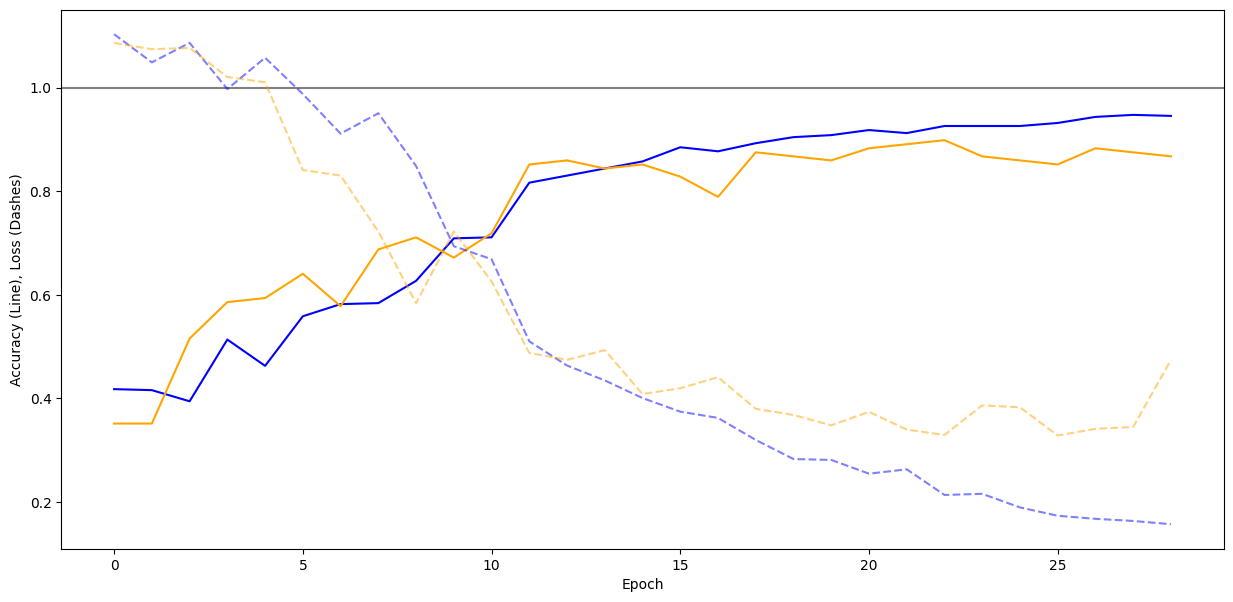

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 62ms/step
before [[3.40979993e-02 9.59657656e-04 9.64942396e-01]
 [9.99689102e-01 3.08918883e-04 2.02856677e-06]
 [9.98578548e-01 2.08320489e-05 1.40060519e-03]
 [1.14920421e-03 1.46265098e-04 9.98704553e-01]
 [9.99674559e-01 2.17597088e-04 1.07861983e-04]
 [9.99977350e-01 2.26647007e-05 4.28440750e-09]
 [9.99930859e-01 4.18556192e-06 6.50069414e-05]
 [1.30502395e-02 9.81031358e-01 5.91834262e-03]
 [9.99790013e-01 2.05823759e-04 4.18769514e-06]
 [9.99174774e-01 6.31927396e-04 1.93262196e-04]
 [7.78283167e-04 2.15112523e-04 9.99006689e-01]
 [1.53496512e-05 9.99979496e-01 5.09801976e-06]
 [8.09581935e-01 1.79805458e-01 1.06125548e-02]
 [7.57987192e-03 2.49187904e-03 9.89928186e-01]
 [9.99984384e-01 1.52973080e-05 3.18469830e-07]
 [2.47879443e-03 1.30040536e-03 9.96220887e-01]
 [1.08611111e-07 9.99999881e-01 3.44314199e-09]
 [1.05258473e-03 1.54159439e-04 9.98793244e-01]
 [3.53861204e-03 9.95256603e-01 1.20465970e-03]
 [5.12103070e-05 1.53070796e-

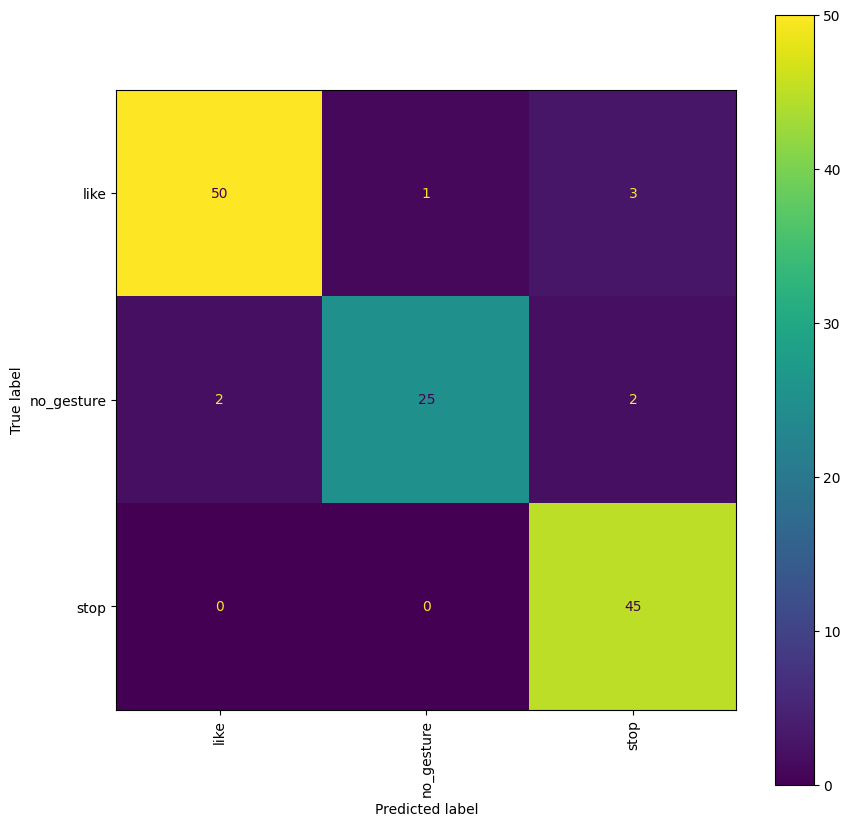

In [50]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

**Results for 13 convolutional layers:** <br>
- prediction accuracy: 0.8672<br>
- inference time: 29 epochs (takes a long time to train the model)

### Model with 5 convolutional layers

In [15]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")v
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## now, we can train the model using the fit() function
## this will take a while

In [16]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 6s 68ms/step - loss: 1.0695 - accuracy: 0.4082 - val_loss: 1.0690 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 3s 50ms/step - loss: 1.0412 - accuracy: 0.3984 - val_loss: 1.0179 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 4s 70ms/step - loss: 0.8354 - accuracy: 0.6191 - val_loss: 0.6693 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 4s 69ms/step - loss: 0.5799 - accuracy: 0.7793 - val_loss: 0.4027 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 4s 63ms/step - loss: 0.4147 - accuracy: 0.8555 - val_loss: 0.7335 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 4s 60ms/step - loss: 0.3550 - accuracy: 0.8809 - val_loss: 0.2676 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 4s 64ms/step - loss: 0.2

In [17]:
# let's have a look at our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (8, 64, 64, 3)            0         
                                                                 
 random_contrast (RandomCont  (8, 64, 64, 3)           0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d (MaxPooling2D  (8, 16, 16, 64)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (8, 6, 6, 32)            0

## Plot accuracy and loss of the training process

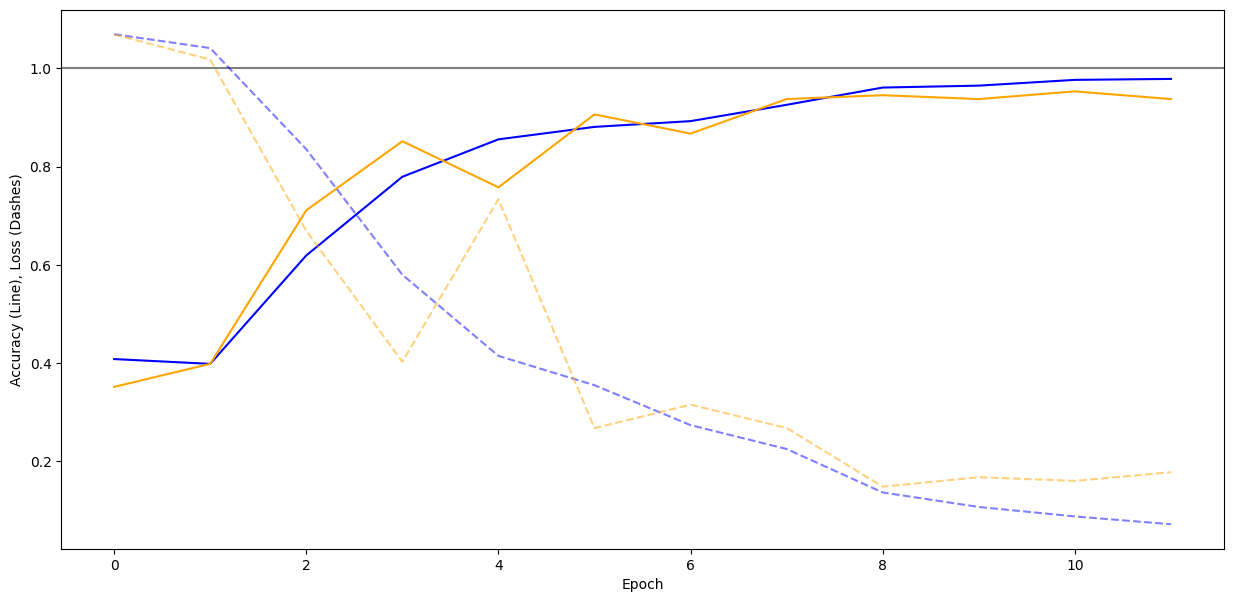

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [ ]:
model.save('gesture_recognition')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

4/4 [==============================] - 2s 35ms/step
before [[3.40979993e-02 9.59657656e-04 9.64942396e-01]
 [9.99689102e-01 3.08918883e-04 2.02856677e-06]
 [9.98578548e-01 2.08320489e-05 1.40060519e-03]
 [1.14920421e-03 1.46265098e-04 9.98704553e-01]
 [9.99674559e-01 2.17597088e-04 1.07861983e-04]
 [9.99977350e-01 2.26647007e-05 4.28440750e-09]
 [9.99930859e-01 4.18556192e-06 6.50069414e-05]
 [1.30502395e-02 9.81031358e-01 5.91834262e-03]
 [9.99790013e-01 2.05823759e-04 4.18769514e-06]
 [9.99174774e-01 6.31927396e-04 1.93262196e-04]
 [7.78283167e-04 2.15112523e-04 9.99006689e-01]
 [1.53496512e-05 9.99979496e-01 5.09801976e-06]
 [8.09581935e-01 1.79805458e-01 1.06125548e-02]
 [7.57987192e-03 2.49187904e-03 9.89928186e-01]
 [9.99984384e-01 1.52973080e-05 3.18469830e-07]
 [2.47879443e-03 1.30040536e-03 9.96220887e-01]
 [1.08611111e-07 9.99999881e-01 3.44314199e-09]
 [1.05258473e-03 1.54159439e-04 9.98793244e-01]
 [3.53861204e-03 9.95256603e-01 1.20465970e-03]
 [5.12103070e-05 1.53070796e-

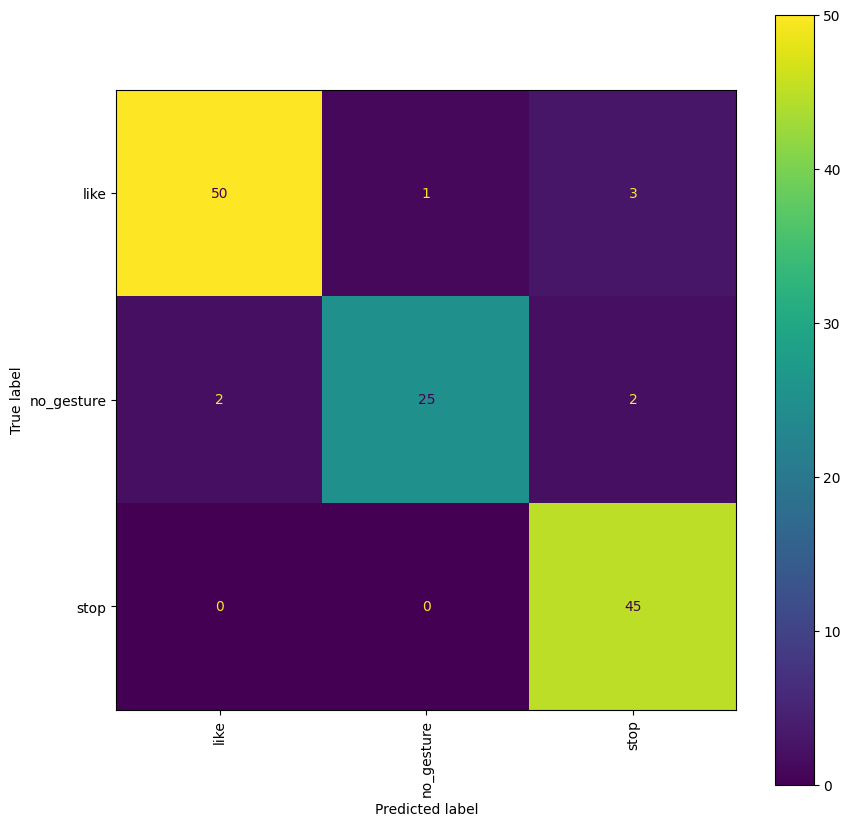

In [19]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

**Results for 5 convolutional layers:** <br>
- prediction accuracy: 0.9375<br>
- inference time: 12 epochs

### Model with 3 convolutional layers

In [20]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_3 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_3.add(RandomFlip('horizontal'))
model_3.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_3.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_3.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_3.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_3.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model_3.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_3.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_3.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_3.add(Dense(num_neurons, activation=activation))

model_3.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_3.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_3.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [21]:
history = model_3.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 4s 38ms/step - loss: 1.0514 - accuracy: 0.4160 - val_loss: 1.0539 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 3s 44ms/step - loss: 1.0098 - accuracy: 0.4609 - val_loss: 0.9129 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 4s 61ms/step - loss: 0.8154 - accuracy: 0.6289 - val_loss: 0.8083 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 4s 64ms/step - loss: 0.6339 - accuracy: 0.7441 - val_loss: 0.7843 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 4s 63ms/step - loss: 0.4489 - accuracy: 0.8242 - val_loss: 0.3846 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 4s 63ms/step - loss: 0.3551 - accuracy: 0.8652 - val_loss: 0.3490 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 4s 68ms/step - loss: 0.2

In [23]:
# let's have a look at our model
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_1 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 conv2d_5 (Conv2D)           (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_3 (MaxPooling  (8, 16, 16, 64)          0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_4 (MaxPooling  (8, 6, 6, 32)           

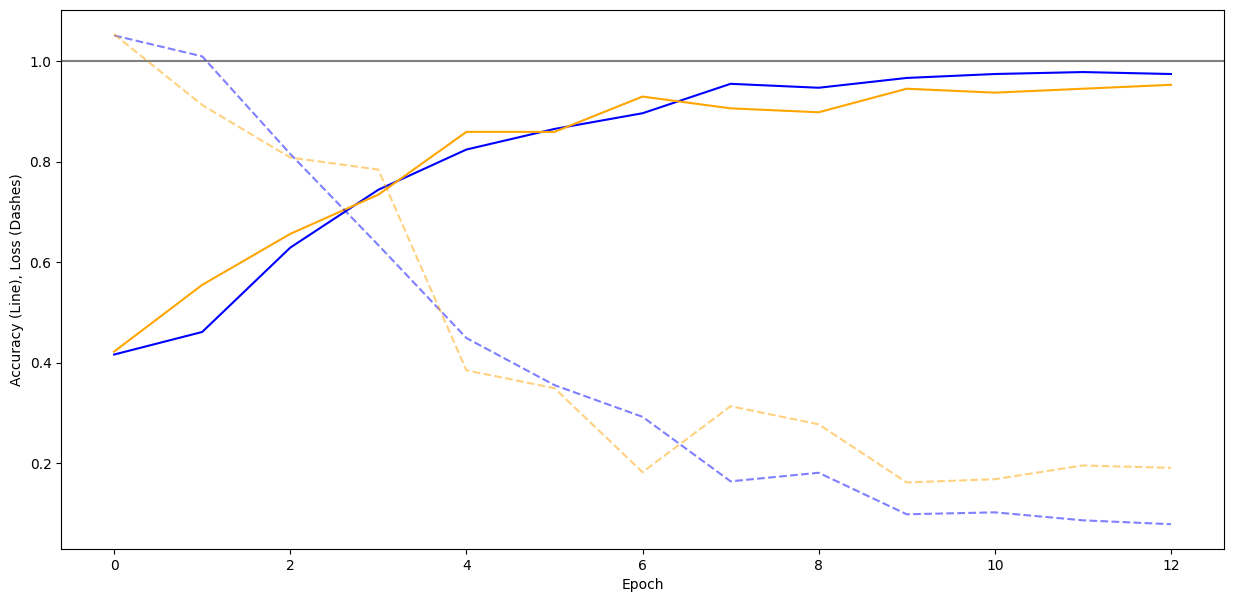

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 31ms/step
before [[9.08580571e-02 1.84760278e-03 9.07294393e-01]
 [9.99531746e-01 3.97678581e-04 7.05101775e-05]
 [9.92241859e-01 1.33848819e-03 6.41962653e-03]
 [1.63125529e-04 1.56293208e-05 9.99821246e-01]
 [9.97545421e-01 8.95616948e-04 1.55902002e-03]
 [9.99978304e-01 2.11660154e-05 4.99452653e-07]
 [9.99928713e-01 1.25579463e-05 5.87711111e-05]
 [1.05657950e-01 8.86022747e-01 8.31929408e-03]
 [9.99200046e-01 6.09374722e-04 1.90536215e-04]
 [9.98447537e-01 6.62667386e-04 8.89689254e-04]
 [4.39523632e-04 1.02207519e-03 9.98538375e-01]
 [1.18568159e-05 9.99973059e-01 1.50920350e-05]
 [7.82330036e-01 1.66012049e-01 5.16579300e-02]
 [2.30968464e-03 2.92260229e-04 9.97398019e-01]
 [9.99999642e-01 3.93845482e-07 4.40700667e-08]
 [2.19892245e-03 7.93524832e-03 9.89865839e-01]
 [3.21230482e-06 9.99992847e-01 3.96938412e-06]
 [1.88943068e-03 7.24598474e-04 9.97385919e-01]
 [2.36843101e-04 9.99437869e-01 3.25298897e-04]
 [1.00023957e-04 2.05763223e-

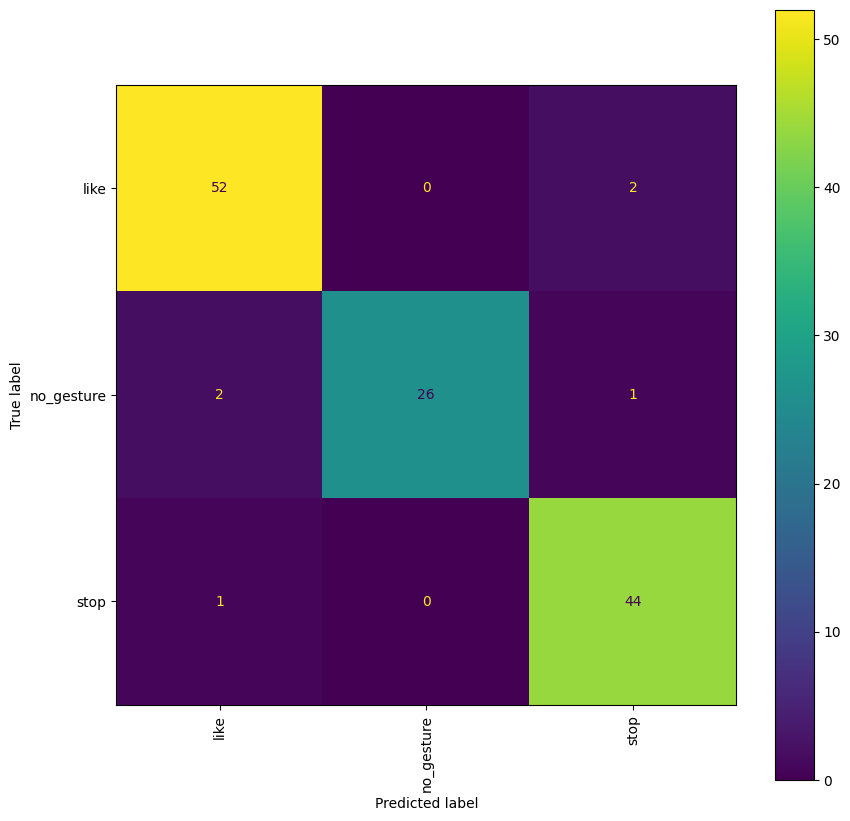

In [25]:
# let the model make predictions for our training data
y_predictions = model_3.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

**Results for 3 convolutional layers:** <br>
- prediction accuracy: 0.9531<br>
- inference time: 13 epochs

### Model with 2 convolutional layers

In [32]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_2 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_2.add(RandomFlip('horizontal'))
model_2.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model_2.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model_2.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model_2.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model_2.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

#model_2.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
#model_2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_2.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_2.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_2.add(Dense(num_neurons, activation=activation))

model_2.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_2.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_2.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [33]:
history = model_2.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 4s 38ms/step - loss: 1.0722 - accuracy: 0.3828 - val_loss: 1.0577 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 3s 41ms/step - loss: 1.0388 - accuracy: 0.4160 - val_loss: 1.0257 - val_accuracy: 0.4297 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 4s 65ms/step - loss: 0.9878 - accuracy: 0.5176 - val_loss: 0.9662 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 4s 69ms/step - loss: 0.7809 - accuracy: 0.6660 - val_loss: 0.5926 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 5s 72ms/step - loss: 0.5019 - accuracy: 0.7949 - val_loss: 0.5203 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 5s 73ms/step - loss: 0.4833 - accuracy: 0.8164 - val_loss: 0.3491 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 5s 72ms/step - loss: 0.3

In [35]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_5 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 conv2d_9 (Conv2D)           (8, 64, 64, 64)           15616     
                                                                 
 max_pooling2d_7 (MaxPooling  (8, 16, 16, 64)          0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (8, 16, 16, 32)           51232     
                                                                 
 max_pooling2d_8 (MaxPooling  (8, 6, 6, 32)           

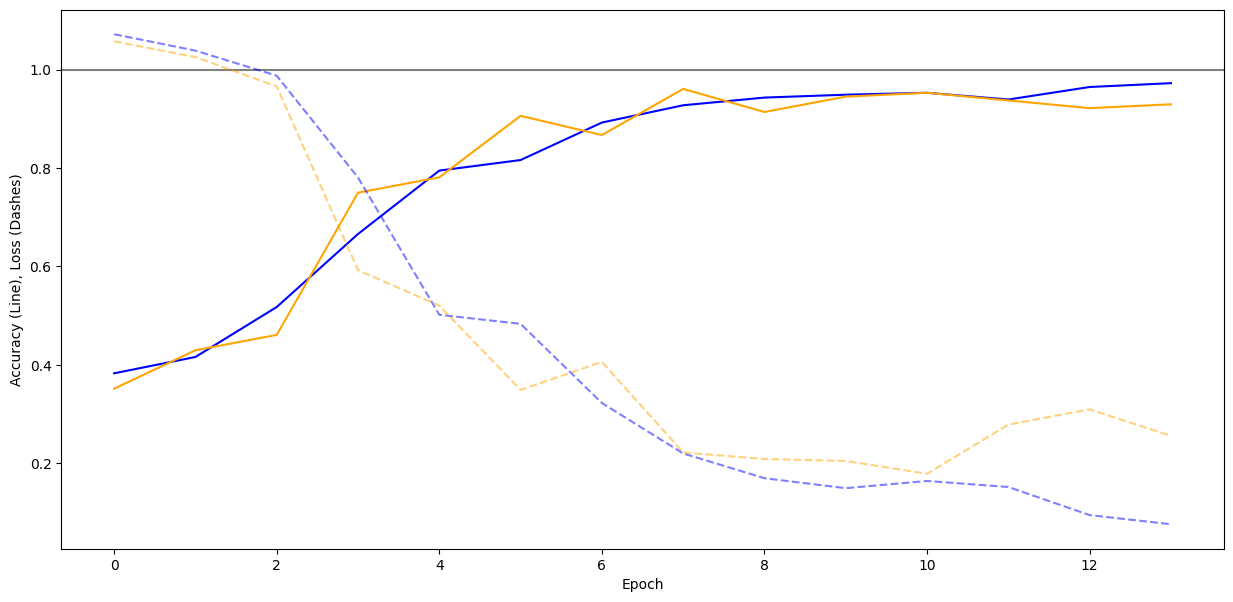

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 37ms/step
before [[9.08580571e-02 1.84760278e-03 9.07294393e-01]
 [9.99531746e-01 3.97678581e-04 7.05101775e-05]
 [9.92241859e-01 1.33848819e-03 6.41962653e-03]
 [1.63125529e-04 1.56293208e-05 9.99821246e-01]
 [9.97545421e-01 8.95616948e-04 1.55902002e-03]
 [9.99978304e-01 2.11660154e-05 4.99452653e-07]
 [9.99928713e-01 1.25579463e-05 5.87711111e-05]
 [1.05657950e-01 8.86022747e-01 8.31929408e-03]
 [9.99200046e-01 6.09374722e-04 1.90536215e-04]
 [9.98447537e-01 6.62667386e-04 8.89689254e-04]
 [4.39523632e-04 1.02207519e-03 9.98538375e-01]
 [1.18568159e-05 9.99973059e-01 1.50920350e-05]
 [7.82330036e-01 1.66012049e-01 5.16579300e-02]
 [2.30968464e-03 2.92260229e-04 9.97398019e-01]
 [9.99999642e-01 3.93845482e-07 4.40700667e-08]
 [2.19892245e-03 7.93524832e-03 9.89865839e-01]
 [3.21230482e-06 9.99992847e-01 3.96938412e-06]
 [1.88943068e-03 7.24598474e-04 9.97385919e-01]
 [2.36843101e-04 9.99437869e-01 3.25298897e-04]
 [1.00023957e-04 2.05763223e-

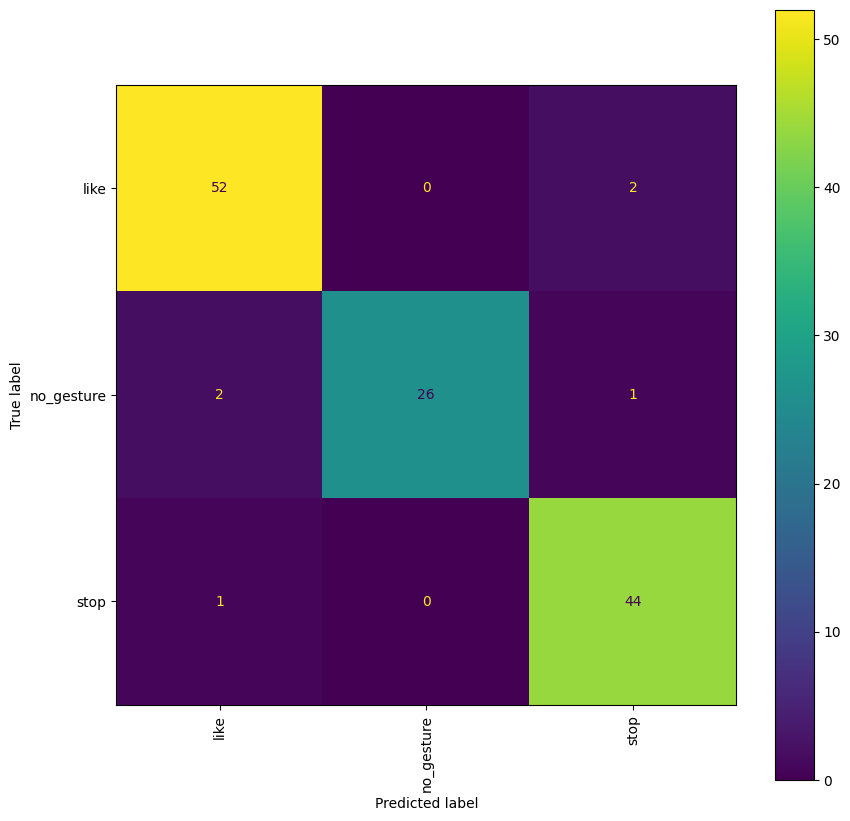

In [37]:
# let the model make predictions for our training data
y_predictions = model_3.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

**Results for 2 convolutional layers:** <br>
- prediction accuracy: 0.9297<br>
- inference time: 14 epochs

### Model with no convolutional layer

In [31]:
# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model_0 = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model_0.add(RandomFlip('horizontal'))
model_0.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
# model_1.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
# model_1.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model_0.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model_0.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model_0.add(Dense(num_neurons, activation=activation))

model_0.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model_0.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model_0.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [51]:
history = model_0.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 [==============================] - 4s 34ms/step - loss: 1.3588 - accuracy: 0.4434 - val_loss: 1.0611 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 2s 31ms/step - loss: 0.9470 - accuracy: 0.5898 - val_loss: 0.9066 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 2s 31ms/step - loss: 0.8276 - accuracy: 0.6465 - val_loss: 1.0893 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 2s 32ms/step - loss: 0.9793 - accuracy: 0.5977 - val_loss: 0.7055 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 2s 32ms/step - loss: 0.6808 - accuracy: 0.7266 - val_loss: 0.6533 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 2s 30ms/step - loss: 0.7679 - accuracy: 0.6719 - val_loss: 0.6388 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 2s 33ms/step - loss: 0.6

In [30]:
# let's have a look at our model
model_0.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_3 (RandomCo  (8, 64, 64, 3)           0         
 ntrast)                                                         
                                                                 
 dropout_3 (Dropout)         (8, 64, 64, 3)            0         
                                                                 
 flatten_3 (Flatten)         (8, 12288)                0         
                                                                 
 dense_9 (Dense)             (8, 64)                   786496    
                                                                 
 dense_10 (Dense)            (8, 64)                   4160      
                                                      

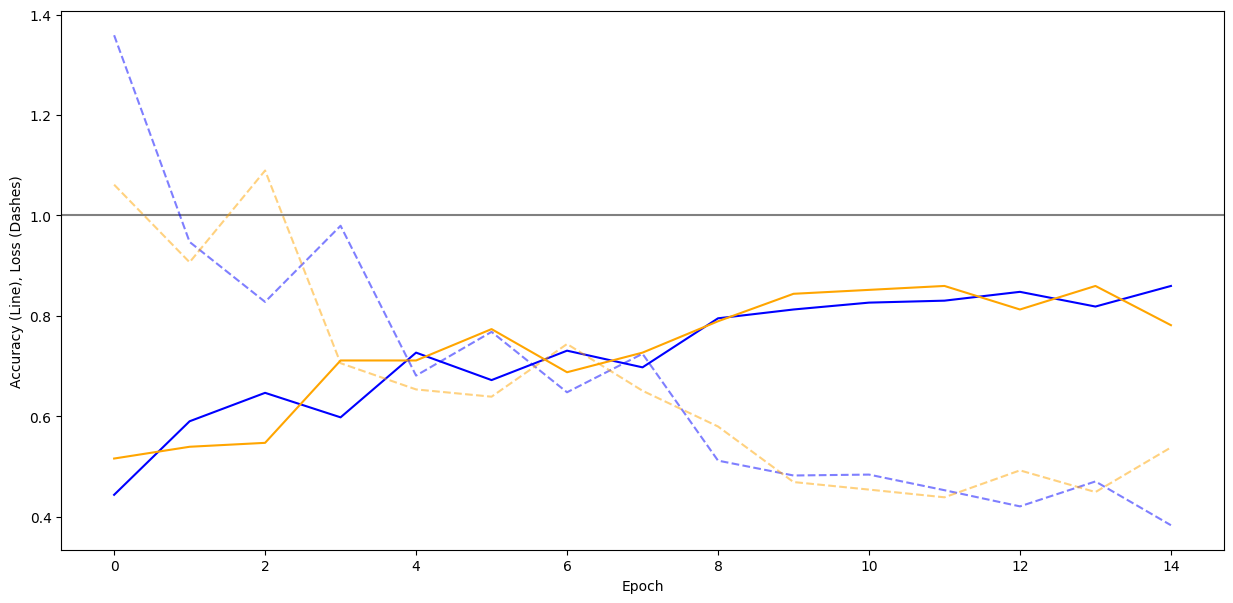

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 [==============================] - 0s 4ms/step
before [[7.01465309e-01 2.63972767e-03 2.95894980e-01]
 [9.85964417e-01 8.79248697e-03 5.24307322e-03]
 [9.36596215e-01 1.14025059e-03 6.22634962e-02]
 [1.28559202e-01 2.76608835e-03 8.68674755e-01]
 [9.87470210e-01 4.77605918e-03 7.75367348e-03]
 [9.99158144e-01 5.64097601e-04 2.77705141e-04]
 [9.72658634e-01 7.06652063e-04 2.66347993e-02]
 [7.16973543e-01 2.74412215e-01 8.61416571e-03]
 [9.95540559e-01 2.20609058e-04 4.23884951e-03]
 [9.79633570e-01 1.33571867e-03 1.90307256e-02]
 [2.74764240e-01 3.40173542e-02 6.91218495e-01]
 [1.64994165e-01 8.07957470e-01 2.70483363e-02]
 [5.43703139e-01 3.19052219e-01 1.37244672e-01]
 [3.21263969e-01 3.15004736e-02 6.47235513e-01]
 [9.99250948e-01 5.71539160e-04 1.77540089e-04]
 [4.17508572e-01 5.38953952e-02 5.28596044e-01]
 [5.00538111e-01 2.92563587e-01 2.06898317e-01]
 [3.65435839e-01 9.79903899e-03 6.24765038e-01]
 [2.24648267e-01 2.75262982e-01 5.00088692e-01]
 [5.01458645e-01 5.53741790e-0

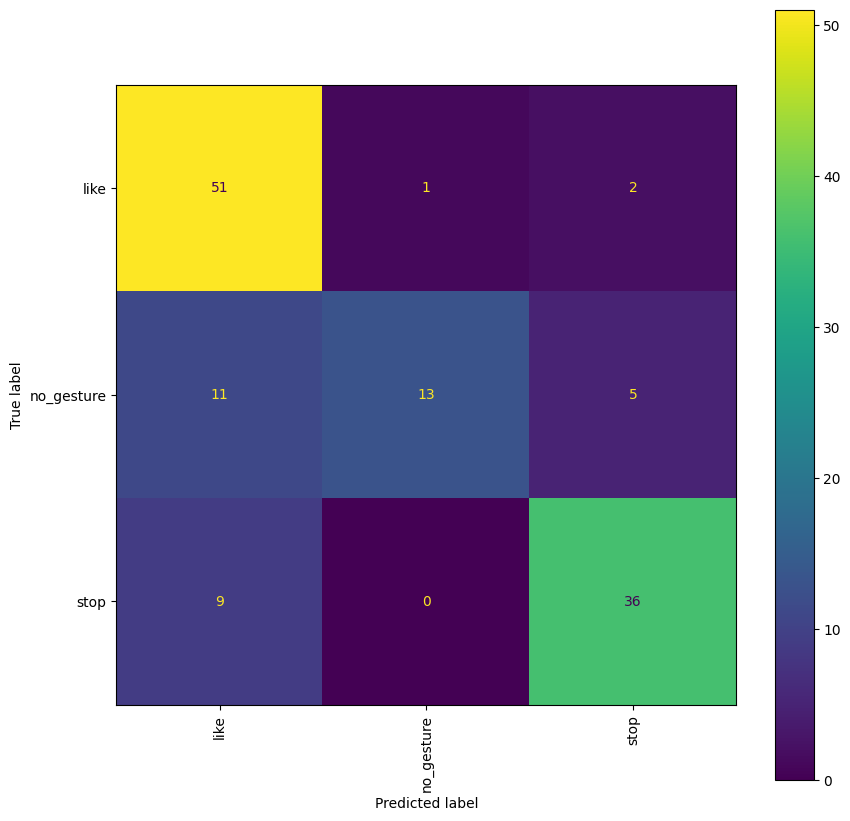

In [53]:
# let the model make predictions for our training data
y_predictions = model_0.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

**Results for 0 convolutional layers:** <br>
- prediction accuracy: 0.7812<br>
- inference time: 15 epochs

## Overall Results

**Results for 13 convolutional layers:** <br>
- prediction accuracy: 0.8672<br>
- inference time: 29 epochs<br>


**Results for 5 convolutional layers:**<br>
- prediction accuracy: 0.9375<br>
- inference time: 12 epochs<br>


**Results for 3 convolutional layers:**<br>
- prediction accuracy: 0.9531<br>
- inference time: 13 epochs<br>


**Results for 2 convolutional layers:**<br>
- prediction accuracy: 0.9297<br>
- inference time: 14 epochs<br>


**Results for 0 convolutional layers:**<br>
- prediction accuracy: 0.7812<br>
- inference time: 15 epochs

=> The model with no convolutional layers has the worst prediction accuracy. An interesting aspect is that the model actually had a lower loss value a few epochs before ending the training/validation, but its performance decreased afterwards. 
If we look at the course of the loss function in the visualizations, the model with 2 or 3 convolutional layers seems to have the most robust training.